In [15]:
### THIS CELL IS JUST FOR 3RD PARTY FUNCTIONS ### 
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))
        
        ## carry over code placed here to reduce clutter


# i did make this tho
def stft( input_sound, dft_size, hop_size, zero_pad, window=1.0):
    length = len(input_sound)
    
    # Part1. splitting into frames
    FrameAmount = math.ceil((length) / hop_size) + 1
    slices = np.arange(dft_size * FrameAmount).reshape(dft_size, FrameAmount)
    # set slices into array
    for i in range(FrameAmount):
        start = i * hop_size
        end = start + dft_size
        
        data = input_sound[start:end]
        
        # input too short... need to zero padd end
        if(data.shape[0] < dft_size):
            zero_padd = np.zeros(dft_size - data.shape[0])
            data = np.hstack((data, zero_padd))
           
        slices[:,i] = data * window
        
    #  Part2. Do fft of input slices        
    size = dft_size+zero_pad   
    if(size%2 ==0):
        NumBins = ((size) // 2) + 1
    else:
        NumBins = ((size) + 1) // 2
    
    NumBins = int(NumBins)
    f = np.arange(NumBins * FrameAmount, dtype=np.complex_).reshape(NumBins, FrameAmount)   
    f[:,:] = 0. + 0.j
    
    for i in range(FrameAmount):
        f[:,i] = np.fft.rfft(slices[:,i], size)      

    # Return a complex-valued spectrogram (frequencies x time)
    return f

def FormatAxis(specArray, sr, time):
    length = specArray.shape[1]
    numbins = specArray.shape[0]
    timeline = np.linspace(0, time, length)
    freqline = np.linspace(0, sr/2, numbins)
    #freqline = np.fft.fftfreq(numbins, d=1./sr)
    return timeline, freqline

def time2sample(time, sr):
    return round(time*sr)

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

Waiting for transcription to complete...
Transcription complete...
['calculate' 'top' 'priority' 'on' 'Mini' 'Bike' 'Fix']
[(0.0, 0.6) (0.6, 0.9) (0.9, 1.1) (1.1, 1.4) (1.4, 1.6) (1.6, 1.9)
 (1.9, 2.2)]
(1,)
(9600,)
(14400,)
(17600,)
(70400,)
(70400,)
(70400,)


old sound


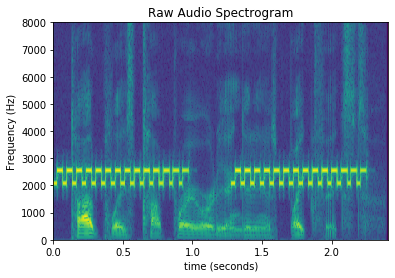

new sound


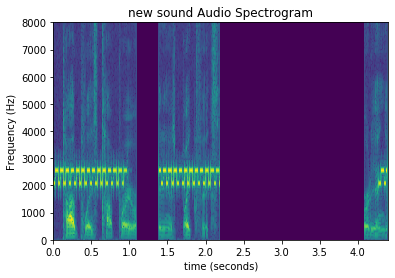

In [62]:
## REAL POC CELL ##

"""
Created on Mon Feb 10 16:36:55 2020
No stealy 
@author: ecouv
"""

from google.cloud import speech_v1
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import speech_recognition as sr
import os
import copy

    
def sample_long_running_recognize(storage_uri):
    """
    Print start and end time of each word spoken in audio file from Cloud Storage

    Args:
      storage_uri URI for audio file in Cloud Storage, e.g. gs://[BUCKET]/[FILE]
    """

    client = speech_v1.SpeechClient()

    # storage_uri = 'gs://cloud-samples-data/speech/brooklyn_bridge.flac'

    # When enabled, the first result returned by the API will include a list
    # of words and the start and end time offsets (timestamps) for those words.
    enable_word_time_offsets = True

    # The language of the supplied audio
    language_code = "en-US"
    config = {
        "enable_word_time_offsets": enable_word_time_offsets,
        "language_code": language_code,
    }
    audio = {"uri": storage_uri}

    operation = client.long_running_recognize(config, audio)

    print(u"Waiting for transcription to complete...")
    response = operation.result()

    # The first result includes start and end time word offsets
    result = response.results[0]
    # First alternative is the most probable result
    alternative = result.alternatives[0]
    print(u"Transcription complete...")
 
        
    return alternative.words

#
# Transcript.words[i] = i-th word
# Transcript.timestamps[i] = start/end times for i-th word
#
def RenderTranscription(oldtrans, newtrans, audio, sr, windowing=False):
    render = np.array([0])
    renderlen = 0

    newtime = newtrans.timestamps
    oldtime = oldtrans.timestamps
    # loop through each word, if this is latest word then extend render
    idx = 0
    for i in range(len(oldtrans.words)):
        
        # get start/end times in samples for slicing
        oldstart_n = time2sample(oldtime[i][0],sr)
        oldend_n = time2sample(oldtime[i][1],sr)
        newstart_n = time2sample(newtime[i][0],sr)
        newend_n = time2sample(newtime[i][1], sr)
        print(render.shape)
        if(newend_n > renderlen):  
            # extend render length 
            l = newend_n - renderlen
            pad = np.zeros(l)
            if(renderlen == 0):
                render = pad
            else:
                render = np.hstack((render, pad))
            renderlen += l
            
        # place audio slice into render
        
        render[newstart_n:newend_n] = audio[oldstart_n:oldend_n]
        idx += 1
    
    
    return render


# shifts by unit of time in seconds
def ShiftTranscriptWord(transcript, index, timeshift):
    
    secs = int(timeshift)
    nanos = int((timeshift - secs) * 10**9)
    
    word = transcript[index]
    
    if(word.start_time.nanos + nanos >= 10**9):
        secs += 1
    if(word.end_time.nanos + nanos >= 10**9):
        secs += 1
    
    word.start_time.seconds += secs
    word.end_time.seconds += secs

    word.start_time.nanos = (word.start_time.nanos + nanos ) % 10**9
    word.end_time.nanos = (word.end_time.nanos + nanos ) % 10**9



class Transcript():
    def __init__(self):
        self.words = np.array(['wordwordwordwordwordword'])
        self.timestamps = np.array([0.0], dtype=object)
        
    def setup(self, transcript):
        self.words = np.repeat(self.words, len(transcript))
        self.timestamps = np.repeat(self.timestamps, len(transcript))
        
        i = 0
        for word in transcript:
            self.words[i] = word.word
            self.timestamps[i] = (word.start_time.seconds + word.start_time.nanos / 10**9 , \
                                  word.end_time.seconds + word.end_time.nanos / 10 ** 9)
            i += 1
    
    
    
#### START ####
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="JSON/My First Project-1534988de9b5.json"

storage_uri = 'gs://ringr_audio/venv/RawAudio/case2.wav'
    
    
sr, case2 = wavfile.read('case2.wav')  
transcript = sample_long_running_recognize(storage_uri)


# create deepcopy to prevent reference copying
newtrans = copy.deepcopy(np.asarray(transcript))


# MAKE NEW TRANSCRIPT

# shift 'top' word by 3 seconds
# case2 only has 7 detected words
# PARAMETERS: TRANSCRIPT, WORDINDEX, TIMESHIFT(+/-seconds)
ShiftTranscriptWord(newtrans, 0, 0)
ShiftTranscriptWord(newtrans, 1, 0)
ShiftTranscriptWord(newtrans, 2, 0)
ShiftTranscriptWord(newtrans, 3, 3)
ShiftTranscriptWord(newtrans, 4, 0)
ShiftTranscriptWord(newtrans, 5, 0)
ShiftTranscriptWord(newtrans, 6, 0)

gtranscript = Transcript()
gtranscript.setup(transcript)
gnewtrans = Transcript()
gnewtrans.setup(newtrans)
print(gtranscript.words)
print(gtranscript.timestamps)


# get new audio from new transcript
newsound = RenderTranscription(gtranscript, gnewtrans, case2, sr)


## plot spectrograms with audio widget
sound(case2, sr, 'old sound')
spec = stft(input_sound=case2, dft_size=256, hop_size=64, zero_pad=256, window=signal.hann(256))
t,f = FormatAxis(spec, sr, len(case2)/sr)
plt.clf()
plt.pcolormesh(t, f, abs(spec)**0.2)
plt.title('Raw Audio Spectrogram')
plt.xlabel('time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.show()


sound(newsound, sr, 'new sound')
spec = stft(input_sound=newsound, dft_size=256, hop_size=64, zero_pad=256, window=signal.hann(256))
t,f = FormatAxis(spec, sr, len(newsound)/sr)
plt.clf()
plt.pcolormesh(t, f, abs(spec)**0.2)
plt.title('new sound Audio Spectrogram')
plt.xlabel('time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.show()




#### 